# New York City Taxi Trip Duration

## Intro

## 1. Frame the problem and look at the big picture

Source : https://www.kaggle.com/c/nyc-taxi-trip-duration

* "In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables."


<b> Data fields </b>

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

## 2. Get the data and setting up the enviroment

In [1]:
import pandas as pd
import numpy as np
import zipfile
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from pathlib import Path
import subprocess
import kaggle.api as kg

In [2]:
#This code will download our datasett from kaggle
kg.competition_download_files(competition='nyc-taxi-trip-duration', path='data/')

In [14]:
#This function will unzip the downloaded data
def extractFile(filename, folder):
    zip_ref = zipfile.ZipFile(folder + '/' + filename, 'r')
    zip_ref.extractall(folder)
    zip_ref.close()

In [16]:
extractFile('train.zip', 'data')
extractFile('test.zip', 'data')

In [52]:
#Create two panda dataframes
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## 3. Explore the data to gain insights

In [21]:
#look at how many collums and attributes there are in the datasett
train.shape

(1458644, 11)

In [22]:
test.shape

(625134, 9)

We notice that there is less attributes in the testing set, witch mean that some attributes may have been deleted

In [23]:
#Lets take a look at how the data is representated
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [24]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


We notice that dropoftime and trip_duration is not a part of the testing set

In [36]:
#Lets check if there is any duplication on the unique id in the set
print(train.duplicated().sum())
print(train.id.duplicated().sum())

0
0


In [37]:
#lets make sure pickups happens before droppoff
sum(train.dropoff_datetime < train.pickup_datetime)

0

In [35]:
desc = train.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
print(desc)

      vendor_id passenger_count pickup_longitude pickup_latitude  \
count   1458644         1458644          1458644         1458644   
mean   1.534950        1.664530       -73.973486       40.750921   
std    0.498777        1.314242         0.070902        0.032881   
min    1.000000        0.000000      -121.933342       34.359695   
25%    1.000000        1.000000       -73.991867       40.737347   
50%    2.000000        1.000000       -73.981743       40.754101   
75%    2.000000        2.000000       -73.967331       40.768360   
max    2.000000        9.000000       -61.335529       51.881084   

      dropoff_longitude dropoff_latitude   trip_duration  
count           1458644          1458644         1458644  
mean         -73.973416        40.751800      959.492273  
std            0.070643         0.035891     5237.431724  
min         -121.933304        32.181141        1.000000  
25%          -73.991325        40.735885      397.000000  
50%          -73.979752        40

There is no missing values in the dataset, there is some large values for tripduratin, and some strange values at passenger count

In [39]:
#Lets find out what values our attributes have
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


We can se that there is some attributes that is of the type object.

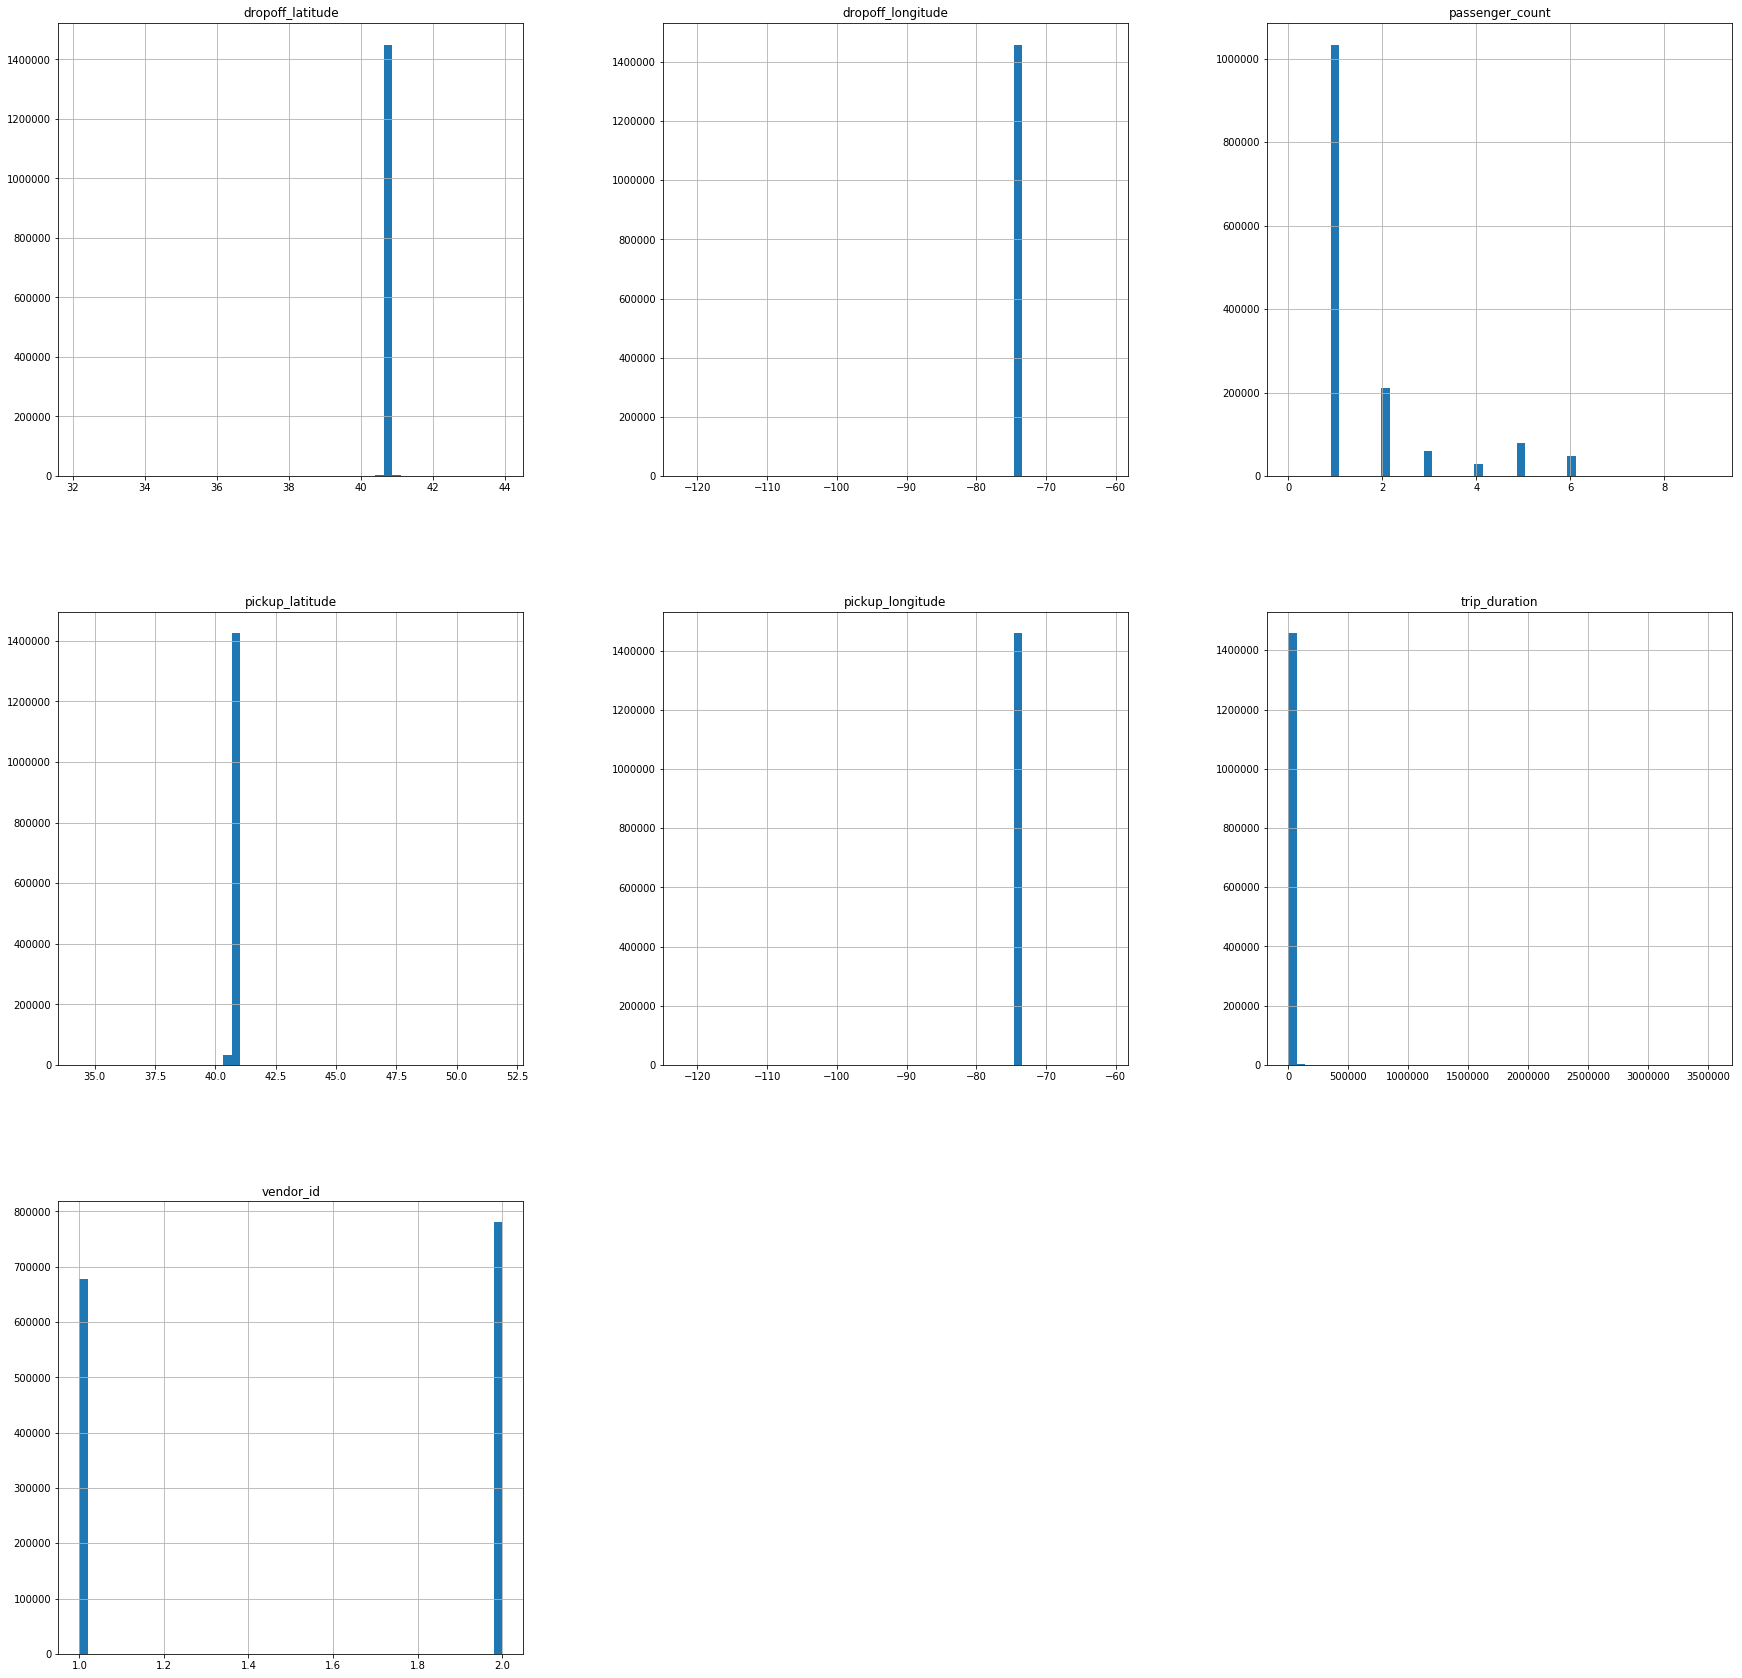

In [40]:
#Take a glimpse of each integer attribute
train.hist(bins=50, figsize=(30,30))
plt.show()

We can se that our longtitude and latitude loaction is very centered, witch we expected based on the name on the dataset, but we can see that there is some values far away fromm the rest. In trip duration there is some huge values

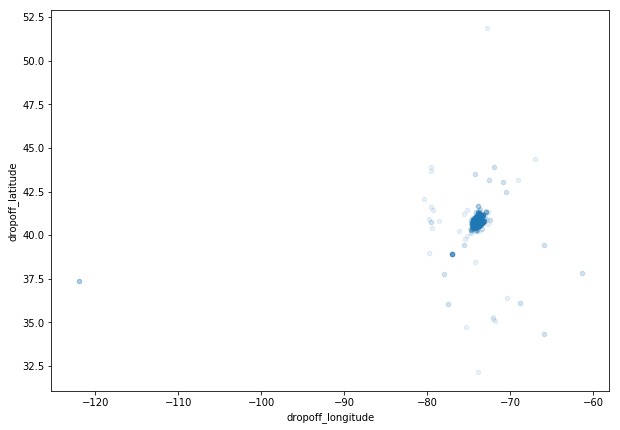

In [41]:
#Lets take a look at all cordinates in the same plot
fig, ax = plt.subplots()
train.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", alpha=0.1, figsize=(10,7), ax=ax)
train.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude", alpha=0.1, figsize=(10,7), ax=ax)
plt.show()

We can clearly see that there is some points far away from the cluster

In [42]:
#Lets se how many rows are above those insane values in trip_duration
print(sum(train["trip_duration"] > 100000))
print(sum(train["trip_duration"] > 50000))
print(sum(train["trip_duration"] > 6000))
print(sum(train["trip_duration"] > 4000))
print(sum(train["trip_duration"] > 2000))

4
1980
2567
8294
84424


We can se that there is only a few values above 6 000, since dataset is so large we can consider removing them.

## 4. Prepare the data

Let go through the dataset, attribute by attribute. Lets start of by transforming all objects into some sort of integer

### Dropoff_datetime

In [49]:
# We can start off by removing the dropoff_datetime since we do not need it, it is basicly the solution
train = train.drop('dropoff_datetime', 1)

### Id

In [73]:
#We do not need the id for anything, other than validation or sorting, so lets remove it
def deleteId(pd):
    return pd.drop('id', 1)

In [74]:
deleteID(train)

In [75]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
